In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import copy
import os

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"
# device = 'cpu'
RESUME = True

CUDA is available!


In [3]:
supervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/train/"
val_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/validation/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/test/"
unsupervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/unsuper/images_gz2/"
batch_size = 8
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
                                  transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()])
train_data = ImageFolder(supervised_path, transform=train_trans)
train_loader = DataLoader(train_data, pin_memory=True, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

unsuper_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(200, 200)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
#                                   transforms.RandomResizedCrop((224, 224)),
                                  transforms.ToTensor()])
unsuper_data = ImageFolder(unsupervised_path, transform=unsuper_trans)
unsuper_loader = DataLoader(unsuper_data, pin_memory=True, batch_size=batch_size, shuffle=True)

tensor([3, 3, 4, 2, 7, 6, 3, 5])
tensor(3)


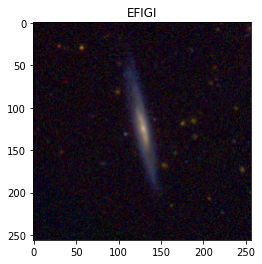

tensor(3)


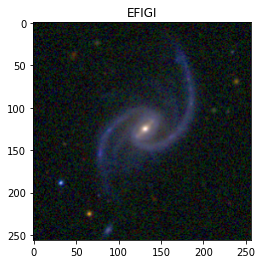

tensor(4)


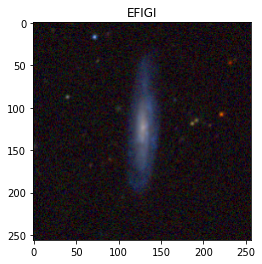

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


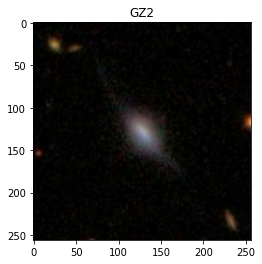

tensor(0)


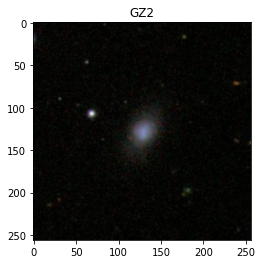

tensor(0)


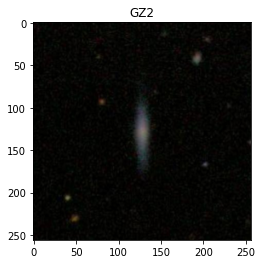

In [4]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.title('EFIGI')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()
    
un_images, un_labels = next(iter(unsuper_loader))
print(un_labels)
for i in np.arange(3):
    print(un_labels[i])
    plt.figure(i)
    plt.title('GZ2')
    plt.imshow(un_images[i].permute(1, 2, 0))
    plt.show()

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(512, 512, 3, padding=1)
        )
    def forward(self, x):
        return self.encoder(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(64,  32, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(32,  3, kernel_size=4, stride=4)
#             nn.ReLU(),
#             nn.ConvTranspose2d(16,  3, kernel_size=2, stride=2)
        )
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
loss_fn = nn.MSELoss()
min_loss = 10000.
# max_loss = 0
# j = 0
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
judge = True
for i in range(12):
    t = tqdm(unsuper_loader)
    for x, _ in t:
        x = x.to(device)
        optimizer.zero_grad()
        
        predict = model(x)
#         print(x.shape)
#         print(predict.shape)
        loss = loss_fn(predict, x)
        loss.backward()
        t.set_description(f"loss: {loss:.10f}")
        if loss < min_loss:
            min_loss = loss
            torch.save(model, 'semi_supervised.pkl')
#         if loss > max_loss:
#             j += 1
#             max_los = loss
#             if j == 150:
#                 judge = False
#         else:
#             j = 0
            
        t.refresh()
        optimizer.step()
        
print()
print("pretraining is done!")

  0%|          | 0/30430 [00:00<?, ?it/s]

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]

  0%|          | 0/30430 [00:00<?, ?it/s]


pretraining is done!


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = Encoder()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(512, 512, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0)
#         )
        self.fc = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(256, 8),
        )
 
    def forward(self, x):
        x = self.encoder(x)
#         x = self.cnn(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [8]:
# model = torch.load('semi_supervised.pkl')
# finetune_loss_fn = nn.CrossEntropyLoss()

# finetune_model = CNN().to(device)
# finetune_optimizer = torch.optim.Adam(finetune_model.parameters(), lr=3e-4, weight_decay=1e-5)
# finetune_model.encoder.load_state_dict(copy.deepcopy(model.encoder.state_dict())) # loads encoder weights from pretrained model

# for epoch in range(20):
#     t = tqdm(train_loader)
#     for x, y in t:
# #         x, y = map(lambda x: x.to(device), [x, y]) # to device, just never mind it.
#         x, y = x.to(device), y.to(device)
# #         print(x.shape)
# #         print(y.shape)
#         finetune_optimizer.zero_grad()
#         logits = finetune_model(x)
# #         print(logits.shape)
#         logits = logits.to(device)
#         loss = finetune_loss_fn(logits, y)
#         loss.backward()
#         t.set_description(f"loss: {loss:.10f}")
#         t.refresh()
#         finetune_optimizer.step()

# print()
# print("finetune is done!")

In [9]:
pre_model = torch.load('semi_supervised.pkl')
finetune_model = CNN().to(device) # 14
# print(finetune_model.state_dict())
data = finetune_model.state_dict()
# print(data.keys())
j = 0
for i in finetune_model.parameters():
    if j == 14:
        break
    j += 1
    i.requires_grad=False
# for i in finetune_model.parameters():
#     print(i)
epoch = 1
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, finetune_model.parameters()), lr=0.00001, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
finetune_model.encoder.load_state_dict(copy.deepcopy(pre_model.encoder.state_dict())) # loads encoder weights from pretrained model
state = {"model":finetune_model.state_dict(), "optimizer":optimizer.state_dict(), "epoch":epoch}
if not os.path.isdir("checkpoint"):
    os.mkdir("checkpoint")
if RESUME:
    print("he")
    checkpoint_path = "./checkpoint/best_4.pth"
    checkpoint = torch.load(checkpoint_path)
    finetune_model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    print(epoch)

he
1


In [10]:
print(epoch)

1


In [11]:
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
# l1_crit = nn.L1Loss(size_average=False)
# factor = 0.03
n_epochs = 100
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    finetune_model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = finetune_model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    finetune_model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = finetune_model(x)
#         reg_loss = 0
        
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        if loss < min_loss:
            min_loss = loss
            torch.save(state, "./checkpoint/best_%s.pth" % (str(epoch)))
#             torch.save(finetune_model, 'E_I_S_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
# torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 1/100 ] loss = 1.59212, acc = 0.41580


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 1/100 ] loss = 1.77497, acc = 0.31724


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 2/100 ] loss = 1.54872, acc = 0.43326


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 2/100 ] loss = 1.77201, acc = 0.24828


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 3/100 ] loss = 1.52516, acc = 0.45436


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 3/100 ] loss = 1.79419, acc = 0.30345


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 4/100 ] loss = 1.49257, acc = 0.45401


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 4/100 ] loss = 1.77054, acc = 0.26897


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 5/100 ] loss = 1.49101, acc = 0.46145


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 5/100 ] loss = 1.79933, acc = 0.31724


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 6/100 ] loss = 1.47624, acc = 0.46387


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 6/100 ] loss = 1.76485, acc = 0.29655


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 7/100 ] loss = 1.45576, acc = 0.47510


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 7/100 ] loss = 1.81552, acc = 0.31034


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 8/100 ] loss = 1.45275, acc = 0.45764


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 8/100 ] loss = 1.79556, acc = 0.28966


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 9/100 ] loss = 1.41808, acc = 0.48116


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 9/100 ] loss = 1.77883, acc = 0.34483


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 10/100 ] loss = 1.39387, acc = 0.50346


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 10/100 ] loss = 1.79140, acc = 0.32414


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 11/100 ] loss = 1.36712, acc = 0.51885


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 11/100 ] loss = 1.73756, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 12/100 ] loss = 1.36488, acc = 0.51815


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 12/100 ] loss = 1.80578, acc = 0.31034


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 13/100 ] loss = 1.33964, acc = 0.51228


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 13/100 ] loss = 1.76770, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 14/100 ] loss = 1.31576, acc = 0.54789


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 14/100 ] loss = 1.75623, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 15/100 ] loss = 1.29871, acc = 0.52714


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 15/100 ] loss = 1.78743, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 16/100 ] loss = 1.25597, acc = 0.54685


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 16/100 ] loss = 1.81291, acc = 0.30345


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 17/100 ] loss = 1.30897, acc = 0.52109


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 17/100 ] loss = 1.77125, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 18/100 ] loss = 1.24008, acc = 0.57331


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 18/100 ] loss = 1.74793, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 19/100 ] loss = 1.23804, acc = 0.56345


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 19/100 ] loss = 1.78846, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 20/100 ] loss = 1.27422, acc = 0.54927


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 20/100 ] loss = 1.78328, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 21/100 ] loss = 1.21305, acc = 0.57071


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 21/100 ] loss = 1.83882, acc = 0.30345


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 22/100 ] loss = 1.21570, acc = 0.57521


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 22/100 ] loss = 1.77887, acc = 0.32414


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 23/100 ] loss = 1.21054, acc = 0.57625


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 23/100 ] loss = 1.78766, acc = 0.29655


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 24/100 ] loss = 1.17695, acc = 0.58887


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 24/100 ] loss = 1.77143, acc = 0.34483


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 25/100 ] loss = 1.15295, acc = 0.59544


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 25/100 ] loss = 1.75499, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 26/100 ] loss = 1.14361, acc = 0.60391


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 26/100 ] loss = 1.78810, acc = 0.31724


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 27/100 ] loss = 1.11550, acc = 0.62517


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 27/100 ] loss = 1.77610, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 28/100 ] loss = 1.09361, acc = 0.63295


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 28/100 ] loss = 1.80877, acc = 0.32414


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 29/100 ] loss = 1.09877, acc = 0.62206


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 29/100 ] loss = 1.80002, acc = 0.36552


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 30/100 ] loss = 1.08310, acc = 0.61912


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 30/100 ] loss = 1.79952, acc = 0.33103


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 31/100 ] loss = 1.05404, acc = 0.63572


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 31/100 ] loss = 1.81666, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 32/100 ] loss = 1.02141, acc = 0.65992


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 32/100 ] loss = 1.84155, acc = 0.33103


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 33/100 ] loss = 1.05924, acc = 0.62932


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 33/100 ] loss = 1.81429, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 34/100 ] loss = 1.00218, acc = 0.67583


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 34/100 ] loss = 1.87404, acc = 0.33103


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 35/100 ] loss = 1.00797, acc = 0.66234


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 35/100 ] loss = 1.83289, acc = 0.29655


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 36/100 ] loss = 1.00170, acc = 0.65871


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 36/100 ] loss = 1.85103, acc = 0.34483


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 37/100 ] loss = 0.97872, acc = 0.67324


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 37/100 ] loss = 1.79705, acc = 0.33793


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 38/100 ] loss = 0.94909, acc = 0.67341


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 38/100 ] loss = 1.82340, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 39/100 ] loss = 0.96582, acc = 0.67946


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 39/100 ] loss = 1.82723, acc = 0.32414


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 40/100 ] loss = 0.95026, acc = 0.68534


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 40/100 ] loss = 1.80882, acc = 0.33793


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 41/100 ] loss = 0.92771, acc = 0.70972


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 41/100 ] loss = 1.87418, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 42/100 ] loss = 0.95500, acc = 0.68309


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 42/100 ] loss = 1.78727, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 43/100 ] loss = 0.92311, acc = 0.68326


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 43/100 ] loss = 1.86173, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 44/100 ] loss = 0.88675, acc = 0.71179


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 44/100 ] loss = 1.85650, acc = 0.35172


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 45/100 ] loss = 0.87949, acc = 0.70868


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 45/100 ] loss = 1.87798, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 46/100 ] loss = 0.86821, acc = 0.70730


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 46/100 ] loss = 1.84422, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 47/100 ] loss = 0.84924, acc = 0.73306


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 47/100 ] loss = 1.85633, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 48/100 ] loss = 0.85767, acc = 0.72355


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 48/100 ] loss = 1.94053, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 49/100 ] loss = 0.83629, acc = 0.73548


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 49/100 ] loss = 1.86653, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 50/100 ] loss = 0.83048, acc = 0.73980


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 50/100 ] loss = 1.82470, acc = 0.40000


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 51/100 ] loss = 0.81468, acc = 0.72372


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 51/100 ] loss = 1.91997, acc = 0.33793


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 52/100 ] loss = 0.79108, acc = 0.74239


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 52/100 ] loss = 1.87060, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 53/100 ] loss = 0.81233, acc = 0.73911


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 53/100 ] loss = 1.83113, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 54/100 ] loss = 0.79791, acc = 0.73738


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 54/100 ] loss = 1.87002, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 55/100 ] loss = 0.76675, acc = 0.75277


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 55/100 ] loss = 1.93231, acc = 0.33793


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 56/100 ] loss = 0.75739, acc = 0.76418


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 56/100 ] loss = 1.92341, acc = 0.40000


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 57/100 ] loss = 0.72386, acc = 0.77109


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 57/100 ] loss = 1.90600, acc = 0.42069


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 58/100 ] loss = 0.70919, acc = 0.78544


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 58/100 ] loss = 1.93801, acc = 0.35862


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 59/100 ] loss = 0.73856, acc = 0.75778


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 59/100 ] loss = 1.95245, acc = 0.40000


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 60/100 ] loss = 0.73452, acc = 0.77230


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 60/100 ] loss = 1.99258, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 61/100 ] loss = 0.70885, acc = 0.78596


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 61/100 ] loss = 1.92576, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 62/100 ] loss = 0.70675, acc = 0.78959


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 62/100 ] loss = 1.92707, acc = 0.42069


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 63/100 ] loss = 0.67291, acc = 0.79737


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 63/100 ] loss = 1.93309, acc = 0.40000


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 64/100 ] loss = 0.65876, acc = 0.80239


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 64/100 ] loss = 1.95076, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 65/100 ] loss = 0.65234, acc = 0.79409


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 65/100 ] loss = 2.00275, acc = 0.36552


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 66/100 ] loss = 0.66656, acc = 0.79357


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 66/100 ] loss = 1.91333, acc = 0.43448


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 67/100 ] loss = 0.67400, acc = 0.79945


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 67/100 ] loss = 1.99328, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 68/100 ] loss = 0.66276, acc = 0.79184


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 68/100 ] loss = 1.94313, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 69/100 ] loss = 0.64158, acc = 0.79979


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 69/100 ] loss = 1.99288, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 70/100 ] loss = 0.61274, acc = 0.81276


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 70/100 ] loss = 2.07295, acc = 0.34483


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 71/100 ] loss = 0.62468, acc = 0.81189


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 71/100 ] loss = 1.97717, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 72/100 ] loss = 0.60614, acc = 0.82279


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 72/100 ] loss = 1.99107, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 73/100 ] loss = 0.61843, acc = 0.80602


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 73/100 ] loss = 1.98954, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 74/100 ] loss = 0.58453, acc = 0.83091


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 74/100 ] loss = 1.96375, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 75/100 ] loss = 0.62612, acc = 0.80826


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 75/100 ] loss = 1.93509, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 76/100 ] loss = 0.60243, acc = 0.82019


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 76/100 ] loss = 2.01711, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 77/100 ] loss = 0.56982, acc = 0.82936


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 77/100 ] loss = 1.91421, acc = 0.42069


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 78/100 ] loss = 0.56766, acc = 0.83610


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 78/100 ] loss = 2.03736, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 79/100 ] loss = 0.53701, acc = 0.84388


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 79/100 ] loss = 1.99800, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 80/100 ] loss = 0.54136, acc = 0.84647


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 80/100 ] loss = 2.14839, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 81/100 ] loss = 0.55890, acc = 0.83195


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 81/100 ] loss = 2.05675, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 82/100 ] loss = 0.55267, acc = 0.83783


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 82/100 ] loss = 2.01319, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 83/100 ] loss = 0.54211, acc = 0.83662


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 83/100 ] loss = 2.02690, acc = 0.41379


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 84/100 ] loss = 0.51347, acc = 0.85581


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 84/100 ] loss = 2.03555, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 85/100 ] loss = 0.51248, acc = 0.85944


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 85/100 ] loss = 2.05150, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 86/100 ] loss = 0.48270, acc = 0.86566


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 86/100 ] loss = 1.98773, acc = 0.42759


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 87/100 ] loss = 0.49757, acc = 0.86324


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 87/100 ] loss = 2.06354, acc = 0.41379


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 88/100 ] loss = 0.51026, acc = 0.85062


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 88/100 ] loss = 1.98194, acc = 0.42069


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 89/100 ] loss = 0.48921, acc = 0.85788


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 89/100 ] loss = 2.10154, acc = 0.39310


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 90/100 ] loss = 0.49281, acc = 0.85373


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 90/100 ] loss = 2.07951, acc = 0.38621


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 91/100 ] loss = 0.47817, acc = 0.87137


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 91/100 ] loss = 2.01487, acc = 0.40000


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 92/100 ] loss = 0.48053, acc = 0.87085


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 92/100 ] loss = 2.04048, acc = 0.42069


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 93/100 ] loss = 0.46675, acc = 0.87552


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 93/100 ] loss = 2.07219, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 94/100 ] loss = 0.44337, acc = 0.87621


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 94/100 ] loss = 2.07455, acc = 0.41379


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 95/100 ] loss = 0.46387, acc = 0.87742


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 95/100 ] loss = 2.09759, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 96/100 ] loss = 0.46196, acc = 0.87085


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 96/100 ] loss = 2.17235, acc = 0.37931


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 97/100 ] loss = 0.42153, acc = 0.89021


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 97/100 ] loss = 2.05812, acc = 0.41379


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 98/100 ] loss = 0.45112, acc = 0.88070


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 98/100 ] loss = 2.17964, acc = 0.37241


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 99/100 ] loss = 0.42907, acc = 0.87967


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 99/100 ] loss = 2.08716, acc = 0.40690


  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 100/100 ] loss = 0.39235, acc = 0.88900


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 100/100 ] loss = 2.30063, acc = 0.37931


In [12]:
!nvidia-smi

Fri Aug 27 21:19:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   56C    P2    42W / 215W |   1717MiB /  7981MiB |     23%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
actu = []
ai_pred = []
finetune_model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in tqdm(test_loader):
    x, y = x.to(device), y.to(device)
    prediction = finetune_model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

  0%|          | 0/145 [00:00<?, ?it/s]

[ Test ] loss = 2.44747, acc = 0.28966


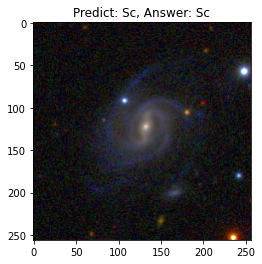

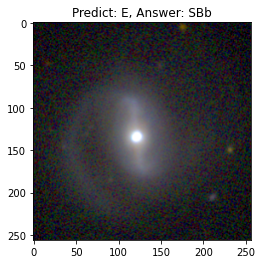

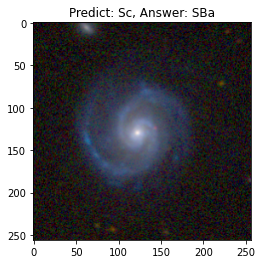

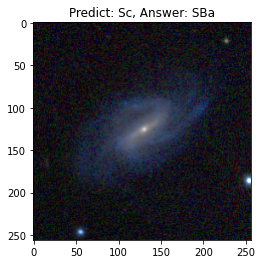

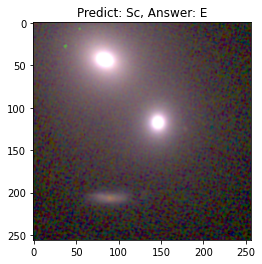

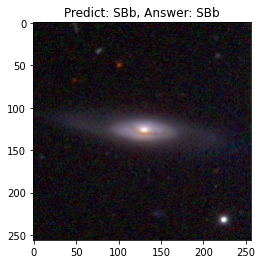

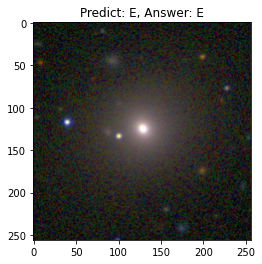

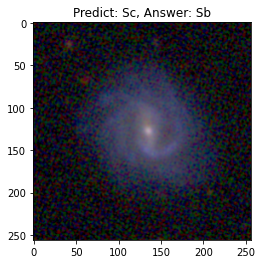

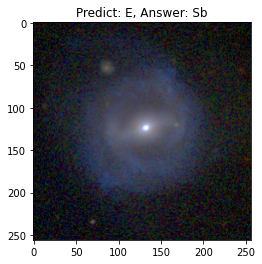

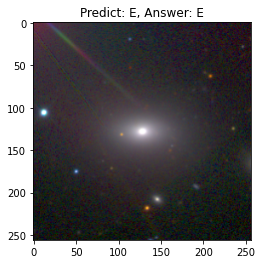

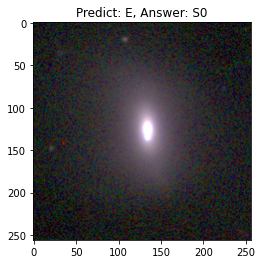

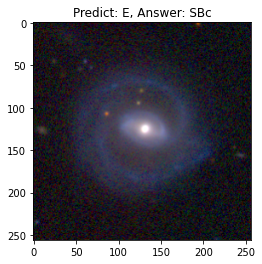

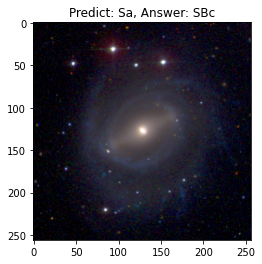

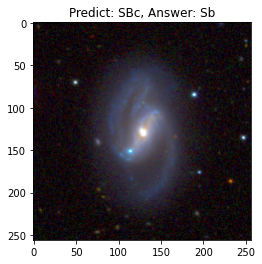

In [14]:
model = torch.load('E_I_S_new.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

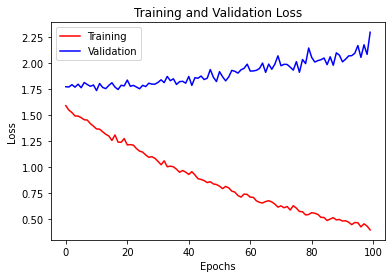

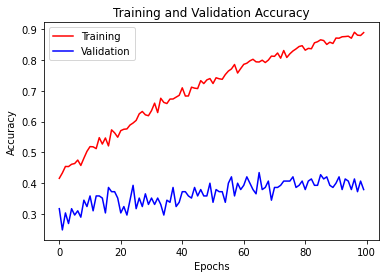

In [15]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [16]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

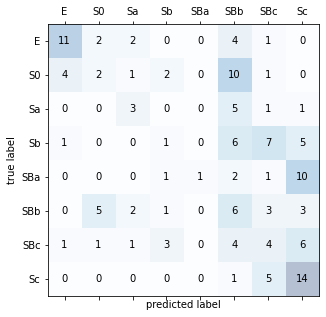

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()